In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
from cartopy import crs as ccrs, feature as cfeature
import os
from os import listdir
from os.path import isfile, join
import pandas as pd
import re
import xarray as xr
from matplotlib.colors import to_hex
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point
import contextily as cx
import geodatasets
import rasterio
from rasterio.transform import from_origin

from scripts.geodata import *

#  Suppress warnings issued by Cartopy when downloading data files
warnings.filterwarnings('ignore')

# reload modules
%load_ext autoreload
%autoreload 2


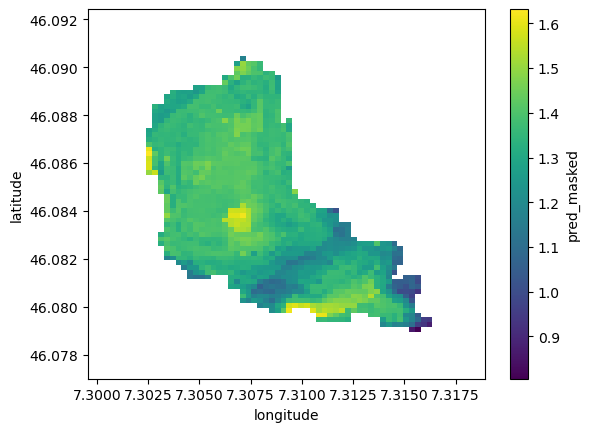

In [2]:
# Step 1: Open the NetCDF file
ds_xy = xr.open_dataset("results/tortin_2022_w_lv95.nc")
ds_latlon = xr.open_dataset("results/tortin_2022_w.nc")
ds_latlon.pred_masked.plot.imshow()

### Transform to geopandas:

In [3]:
gdf, lon, lat = toGeoPandas(ds_latlon)

# Now the GeoDataFrame is created with matching shapes!
print(gdf.head())

# Reproject to LV95 (EPSG:2056)
gdf_lv95 = gdf.to_crs("EPSG:2056")

   data                  geometry
0   NaN  POINT (7.29971 46.09233)
1   NaN      POINT (7.3 46.09233)
2   NaN  POINT (7.30028 46.09233)
3   NaN  POINT (7.30057 46.09233)
4   NaN  POINT (7.30085 46.09233)


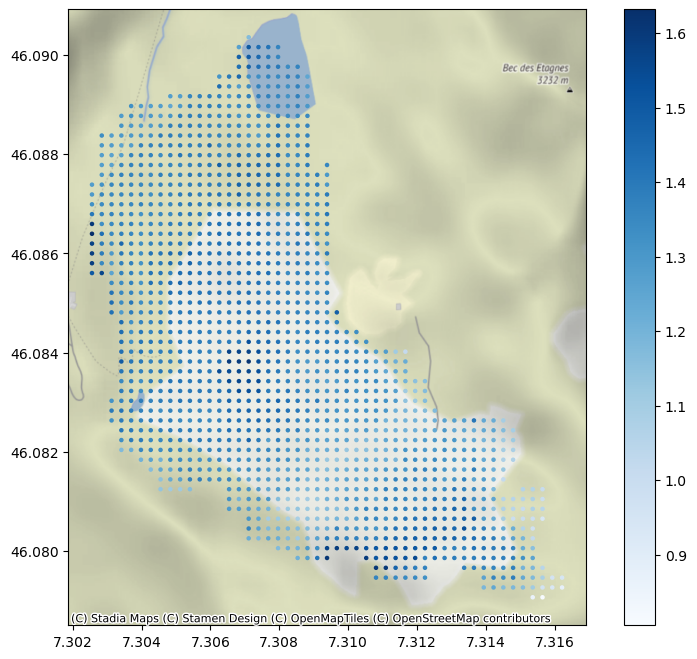

In [4]:
API_KEY = "000378bd-b0f0-46e2-a46d-f2165b0c6c02"

# Create a dataframe with the New York boroughs sample dataset
# df = gpd.read_file(geodatasets.get_path("nybb"))

# Add your API key to the desired style from contextily providers
provider = cx.providers.Stadia.StamenTerrain(api_key=API_KEY)

# Update the provider URL to include your API key
provider["url"] = provider["url"] + f"?api_key={API_KEY}"
# cx.providers.Stadia

# Define the plot size, transparency, and edge color
# ax = gdf.plot(figsize=(10, 10), alpha=0.5)

fig, ax = plt.subplots(figsize=(10, 8))

gdf_clean = gdf.dropna(subset=["data"])

gdf_clean.plot(
    column="data",  # Column to visualize
    cmap="Blues",  # Color map suitable for glacier data
    legend=True,  # Display a legend
    ax=ax,
    markersize=5,  # Adjust size if points are too small or large
    missing_kwds={"color": "lightgrey"}  # Define color for NaN values
)

# Draw the basemap under the plot, define the Coordinate Reference System, and add the updated provider object as the source
cx.add_basemap(ax, crs=gdf.crs, source=provider)

### Transform to raster:

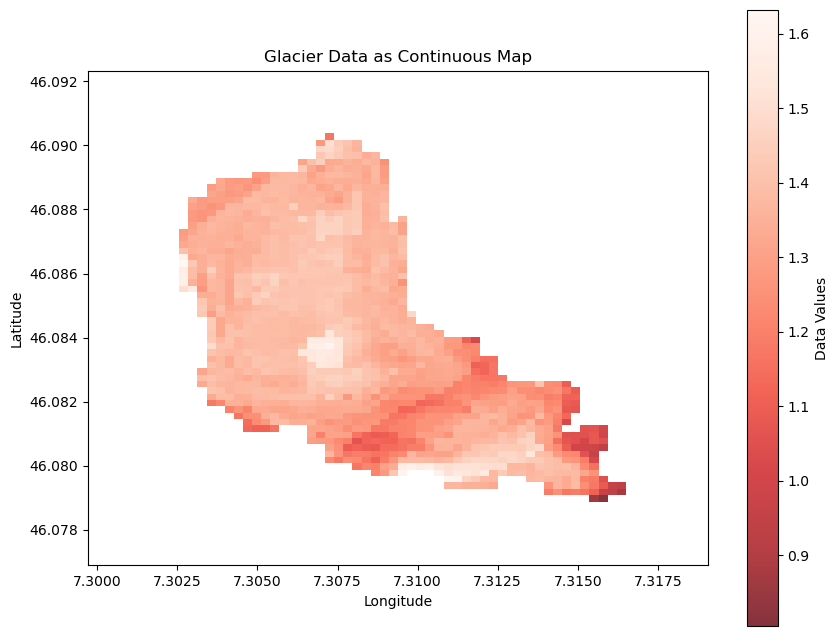

In [5]:
tif_name = "results/tortin_2022_w.tif"
raster_data, extent = toRaster(gdf, lon, lat, tif_name)

# Plot the raster
plt.figure(figsize=(10, 8))
plt.imshow(raster_data,
           extent=extent,
           cmap='Reds_r',
           vmin=np.nanmin(raster_data),
           vmax=np.nanmax(raster_data),
           alpha=0.8)
plt.colorbar(label='Data Values')
plt.title('Glacier Data as Continuous Map')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

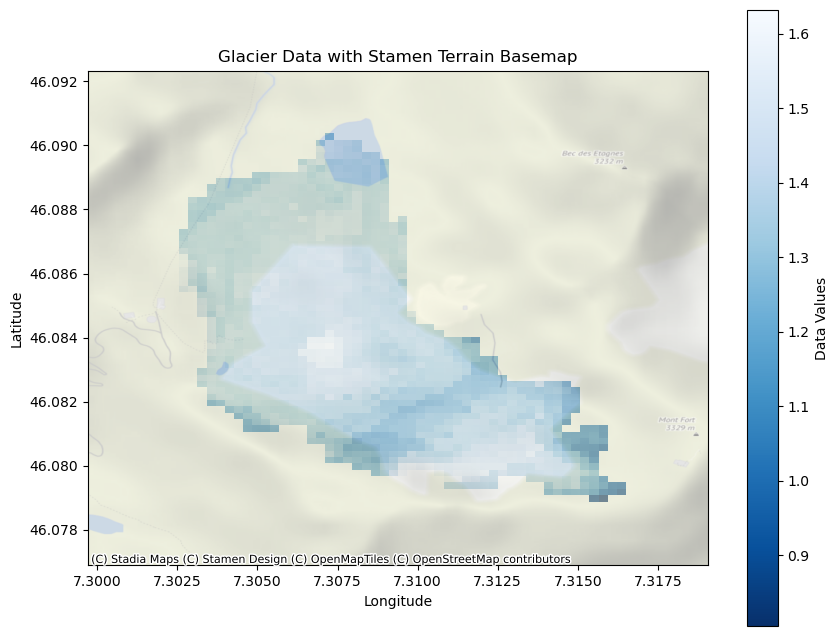

In [6]:
# raster_data, extent = toRaster_reproj(gdf, lon, lat)

src_crs = 'EPSG:4326'

# Set up the plot
fig, ax = plt.subplots(figsize=(10, 8))

# Calculate vmin and vmax ignoring NaN values
vmin = np.nanmin(raster_data)  # Min value, ignoring NaNs
vmax = np.nanmax(raster_data)  # Max value, ignoring NaNs

# Ensure vmin is less than or equal to vmax before plotting
img = ax.imshow(raster_data,
                extent=extent,
                cmap='Blues_r',
                vmin=vmin,
                vmax=vmax,
                alpha=1,)

# Add the Stamen Terrain basemap
cx.add_basemap(ax, crs=src_crs, source=provider, alpha = 0.5)

# Add a colorbar and labels
plt.colorbar(img, ax=ax, label='Data Values')
ax.set_title('Glacier Data with Stamen Terrain Basemap')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

In [7]:
from rasterio.warp import calculate_default_transform, reproject, Resampling

def reproject_raster_to_lv95(input_raster, output_raster):
    # Define the source and destination CRS
    src_crs = 'EPSG:4326'  # Original CRS (lat/lon)
    dst_crs = 'EPSG:2056'  # Destination CRS (Swiss LV95)

    # Open the source raster
    with rasterio.open(input_raster) as src:
        # Calculate the transform and dimensions for the destination CRS
        transform, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds
        )

        # Set up the destination raster metadata
        dst_meta = src.meta.copy()
        dst_meta.update({
            'crs': dst_crs,
            'transform': transform,
            'width': width,
            'height': height
        })

        # Perform the reprojection
        with rasterio.open(output_raster, 'w', **dst_meta) as dst:
            for i in range(1, src.count + 1):  # Iterate over each band
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=Resampling.nearest  # You can also use other methods, like bilinear
                )

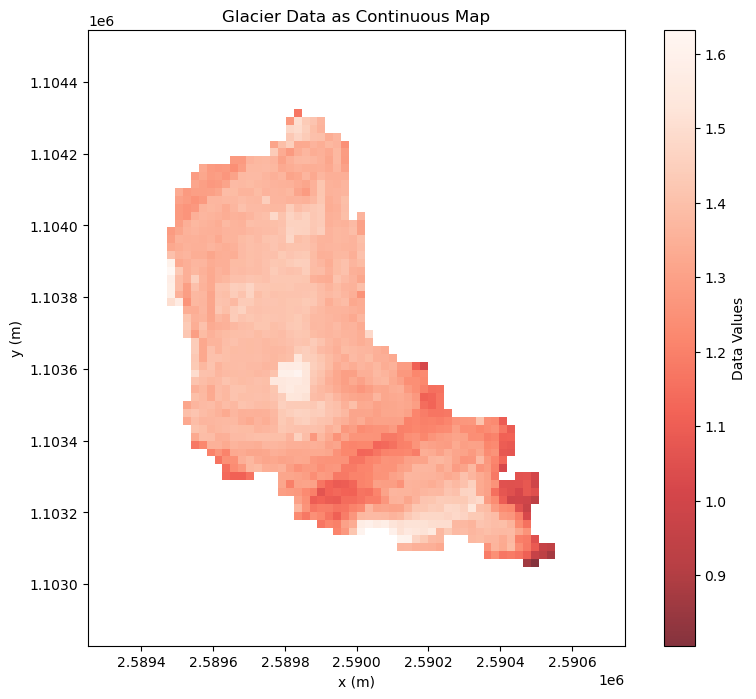

In [8]:
# reproject raster to swiss coordinates
input_raster = "results/tortin_2022_w.tif"
output_raster = "results/tortin_2022_w_lv95.tif"
reproject_raster_to_lv95(input_raster, output_raster)

# open the reprojected raster
with rasterio.open(output_raster) as src:
        raster_data = src.read(1)  # Read the first band
        extent = [
            src.bounds.left, src.bounds.right, src.bounds.bottom,
            src.bounds.top
        ]
        
# Plot the raster
plt.figure(figsize=(10, 8))
plt.imshow(raster_data,
           extent=extent,
           cmap='Reds_r',
           vmin=np.nanmin(raster_data),
           vmax=np.nanmax(raster_data),
           alpha=0.8)
plt.colorbar(label='Data Values')
plt.title('Glacier Data as Continuous Map')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.show()